# Roadmap

I'm a somewhat amateur photographer with a bad memory of where photos were taken. When we take photos w/ a smartphone, the GPS on the phone records the location where the photo is taken.

However, I take a lot of photos w/ this thing...
<img src="https://multimedia.bbycastatic.ca/multimedia/products/500x500/103/10347/10347557.jpg" alt="camera" style="width: 200px;"/>

This thing doesn't have a built in GPS chip, so locations of the photos are not stored by default :(

Fortunately, I almost always have my phone with me, and I'm not too worried about privacy so I let Google track my location.
![Location History](https://www.dropbox.com/s/7f6m4qsktwj4qyp/locationhistory_1.png?dl=1)

We can combine the time information from the camera with the Google location history timestamps to add back our geo data.

**The plan of this notebook is to do the following:**

1. Read in and parse JSON format Google location data (download location history from
[https://takeout.google.com/settings/takeout](https://takeout.google.com/settings/takeout))
<img src="https://www.dropbox.com/s/apmdvqhujr375mx/locationhistory_0.png?dl=1" alt="camera" style="width: 500px;"/>
2. Read in meta data from your photos using exifread package

3. Match photos to google location based on closest timestamp

4. Map the data using folium

5. Resize matched images, save in new folder.

6. Add photos to map.



In [12]:
import os
import pandas as pd
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import re
import numpy as np
import exifread # pip install exifread

# Read google data

In [13]:
import json
with open('../google_data/Location History/LocationHistory.json') as fi:
    f = fi.read()
f = json.loads(f)

In [14]:
f['locations'][:2] # data organized as such

[{u'accuracy': 20,
  u'latitudeE7': 297180613,
  u'longitudeE7': -953737224,
  u'timestampMs': u'1462165225626'},
 {u'accuracy': 36,
  u'latitudeE7': 297181054,
  u'longitudeE7': -953737030,
  u'timestampMs': u'1462165163009'}]

In [15]:
loc = f['locations']
loc = pd.DataFrame(loc)
loc['timestamp'] = loc.timestampMs.apply(lambda x: datetime.datetime.fromtimestamp(float(x)/1000).strftime('%Y-%m-%d %H:%M:%S.%f'))
loc['timestamp'] = pd.to_datetime(loc.timestamp)
loc['date'] = loc.timestamp.apply(lambda x: datetime.date(x.year, x.month, x.day))
loc['long'] = loc.longitudeE7.apply(lambda x: x/1e7)
loc['lat'] = loc.latitudeE7.apply(lambda x: x/1e7)

In [16]:
loc.head()

,accuracy,activitys,altitude,heading,latitudeE7,longitudeE7,timestampMs,velocity,timestamp,date,long,lat
0,20,NaN,NaN,NaN,297180613,-953737224,1462165225626,NaN,2016-05-01 23:00:25.626,2016-05-01,-95.373722,29.718061
1,36,NaN,NaN,NaN,297181054,-953737030,1462165163009,NaN,2016-05-01 22:59:23.009,2016-05-01,-95.373703,29.718105
2,32,NaN,NaN,NaN,297181364,-953736852,1462165102912,NaN,2016-05-01 22:58:22.912,2016-05-01,-95.373685,29.718136
3,20,NaN,NaN,NaN,297180538,-953737277,1462165042754,NaN,2016-05-01 22:57:22.754,2016-05-01,-95.373728,29.718054
4,20,NaN,NaN,NaN,297180468,-953737299,1462164982486,NaN,2016-05-01 22:56:22.486,2016-05-01,-95.373730,29.718047


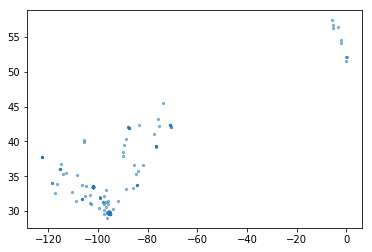

In [17]:
loc_days = loc.groupby('date')[['long', 'lat']].mean()
plt.scatter(loc_days['long'], loc_days['lat'], s = 5, alpha = .5)

# read exif data 

In [19]:
flist = ['../JPEGs/flickr/'+f for f in os.listdir('../JPEGs/flickr')]
fnames = [f for f in os.listdir('../JPEGs/flickr')]

In [20]:
captimes = list()
for fi in flist:
    with open(fi, 'r') as f:
        tags = exifread.process_file(f)
        try:
            captime = str(tags['EXIF DateTimeOriginal'])
            captime = datetime.datetime.strptime(captime, '%Y:%m:%d %H:%M:%S')
        except:
            captime = pd.NaT
        captimes.append(captime)
captimes = pd.to_datetime(captimes)
df = pd.DataFrame(list(zip(fnames, captimes)))
df.columns = ['fname','timestamp']
# DF.append(df)
df['fpath'] = flist
df['thumbs_rel'] = df.loc[:, 'fpath'].apply(lambda x: '../JPEGs/flickr_resized/'+re.findall('flickr/([^\.]+\.[^ ]+)', x)[0])
df['thumbs'] = df.loc[:, 'fpath'].apply(lambda x: x.replace('/flickr/', '/flickr_resized/'))

# match photo catalog to geotags

In [22]:
loc.sort_values(by = ['timestamp'], inplace = True)
loctimes = list(loc.timestamp)
indices = list(loc.index)

In [23]:
ind = np.argmin(np.absolute(np.array(loctimes)-df.timestamp[0])) # example: find closest index for first photo

In [24]:
loc.loc[ind, ['long', 'lat']] # the corresponding location 

long   -95.3738
lat      29.718
Name: 78313, dtype: object

In [26]:
from bisect import bisect_left # use bisection method to find closest time match 

# note that numpy also has a search sorted method that does the same thing as the takeClosest function

def takeClosest(myList, myNumber):
    """
    Assumes myList is sorted. Returns closest value to myNumber.

    If two numbers are equally close, return the smallest number.
    """
    pos = bisect_left(myList, myNumber)
    if pos == 0:
        return myList[0]
    if pos == len(myList):
        return myList[-1]
    before = myList[pos - 1]
    after = myList[pos]
    if after - myNumber < myNumber - before: # if the timestamp after is closer than timestamp before, return after position
        return pos
    else: # otherwise return before position
        return pos-1

In [27]:
if 1==1: # This may take some time to run, note, we can do this in parallel which would speed it up ~p times, where p is the numer of virtual processors
    df.loc[-df.timestamp.isnull(), 'locpos'] = df.loc[-df.timestamp.isnull(), 
                                                      'timestamp'].apply(lambda x: takeClosest(sorted(loctimes),x)-1)
else:
    pass

In [14]:
lnglats = loc[['long', 'lat', 'timestamp']].to_dict()

In [29]:
df.loc[-df.locpos.isnull(), 'locpos'] = df.loc[-df.locpos.isnull(), 'locpos'].apply(lambda x: indices[int(x)])

In [32]:
loc.reset_index(inplace = True)
loc.head()

,index,accuracy,activitys,altitude,heading,latitudeE7,longitudeE7,timestampMs,velocity,timestamp,date,long,lat
0,887279,45,NaN,NaN,NaN,297127358,-953652635,1390861889886,NaN,2014-01-27 15:31:29.886,2014-01-27,-95.365263,29.712736
1,887278,31,"[{u'activities': [{u'confidence': 50, u'type':...",NaN,NaN,297127175,-953652558,1390861904207,NaN,2014-01-27 15:31:44.207,2014-01-27,-95.365256,29.712718
2,887277,61,NaN,NaN,NaN,297126759,-953652556,1390861951332,NaN,2014-01-27 15:32:31.332,2014-01-27,-95.365256,29.712676
3,887276,4,"[{u'activities': [{u'confidence': 100, u'type'...",-13.0,NaN,297127660,-953653252,1390861993918,0.0,2014-01-27 15:33:13.918,2014-01-27,-95.365325,29.712766
4,887275,3,NaN,-13.0,NaN,297127657,-953653224,1390862005879,0.0,2014-01-27 15:33:25.879,2014-01-27,-95.365322,29.712766


In [35]:
df = df.loc[~df.locpos.isnull(),:].merge(loc, how = 'left', left_on = 'locpos', right_on = 'index')

# Write location metadata to photos/ write thumbs for map

In [34]:
# make thumbnails
from PIL import Image
from resizeimage import resizeimage
os.chdir('C://Users/yangyang2000/Dropbox/Photos/GeoTagging/JPEGs/flickr/')
flist = os.listdir('.')
for i, fi in enumerate(flist):
    with open(fi, 'r+b') as f:
        with Image.open(f) as image:
            cover = resizeimage.resize_thumbnail(image, [400, 300])
            cover.save('../flickr_resized/'+fi, image.format)
    if i % 100 == 0:
        print str(i)+ ' completed out of '+str(len(flist))

0 completed out of 1313
100 completed out of 1313
200 completed out of 1313
300 completed out of 1313
400 completed out of 1313
500 completed out of 1313
600 completed out of 1313
700 completed out of 1313
800 completed out of 1313
900 completed out of 1313
1000 completed out of 1313
1100 completed out of 1313
1200 completed out of 1313
1300 completed out of 1313


# Map/Visualize the data

This requires package folium. Install using in command prompt/terminal:
``pip install folium``

In [37]:
import folium

In [38]:
from folium.plugins import MarkerCluster

In [41]:
df.columns.values

array(['fname', 'timestamp_x', 'fpath', 'thumbs_rel', 'thumbs', 'locpos',
       'index', u'accuracy', u'activitys', u'altitude', u'heading',
       u'latitudeE7', u'longitudeE7', u'timestampMs', u'velocity',
       'timestamp_y', 'date', 'long', 'lat'], dtype=object)

In [40]:
lons = list(df.loc[-df.locpos.isnull(), 'long'])
lats = list(df.loc[-df.locpos.isnull(), 'lat'])
timestamp = list(df.loc[-df.locpos.isnull(), 'timestamp_x'])
locations = list(zip(lats, lons))

In [47]:
bigphotos =list(df.fpath) 
popups = list(df.thumbs_rel)
popups = ['<img src="' +f+ '" alt="photo">' for f in popups] # popups are html code

In [48]:
fotomap = folium.Map(location=[np.mean(lats), np.mean(lons)],
                  tiles='Stamen Toner', zoom_start=1)
fotomap.add_children(MarkerCluster(locations=locations, popups=popups))
fotomap.save('./meetup_map.html') # Save map to this location

C:\Anaconda\lib\site-packages\ipykernel\__main__.py:3: FutureWarning: Method `add_children` is deprecated. Please use `add_child` instead.
  app.launch_new_instance()


# ToDo's...

1. Need to adjust timestamp based on timezone... need to figure out what timezone my camera's set in first, just too lazy right now.
2. Need to fix popup autosize... involves adding a leaflet function in javascript